## Problem Statement

## Problem Statement

### Objective 🎯
Can we develop a versatile Python agent, powered by ChatGPT, capable of addressing a range of data-related challenges, including code verification, chart generation, machine learning model training, and model comparison. The agent should understand and execute natural language commands for these tasks, providing a user-friendly interface for individuals with varying technical expertise.

### Specific Tasks 📋
The Python agent should be able to perform the following tasks:

1. **Code Verification 🧾**
   - Review and validate Python code provided in natural language.
   - Provide feedback on code correctness and suggest improvements.

2. **Chart Generation 📊**
   - Generate charts and graphs based on data descriptions provided in natural language.
   - Translate data requirements into code to fetch, preprocess, and visualize the data.
   <div align="left">
   <kbd>
   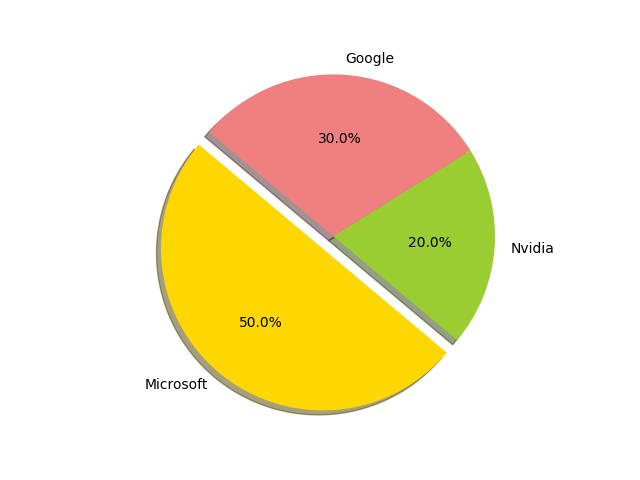
   </kbd>
   </div>

3. **Machine Learning Model Training 🤖**
   - Train machine learning models using libraries like scikit-learn, TensorFlow, or PyTorch.
   - Assist with data preprocessing, model selection, hyperparameter tuning, and monitoring of training.
   <div align="left">
   <kbd>
   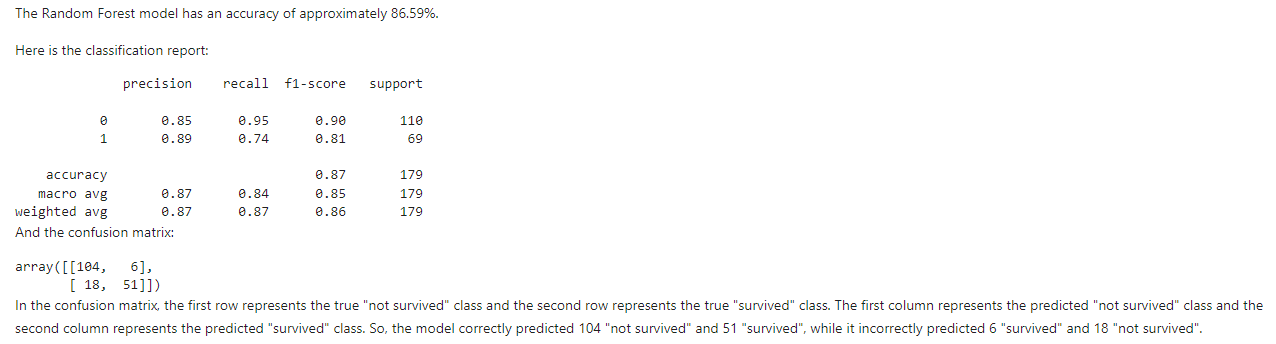
   </kbd>
   </div>

4. **Model Comparison 📈**
   - Compare machine learning models based on user-defined criteria.
   - Explain differences in model performance in natural language.
   <div align="left">
   <kbd>
   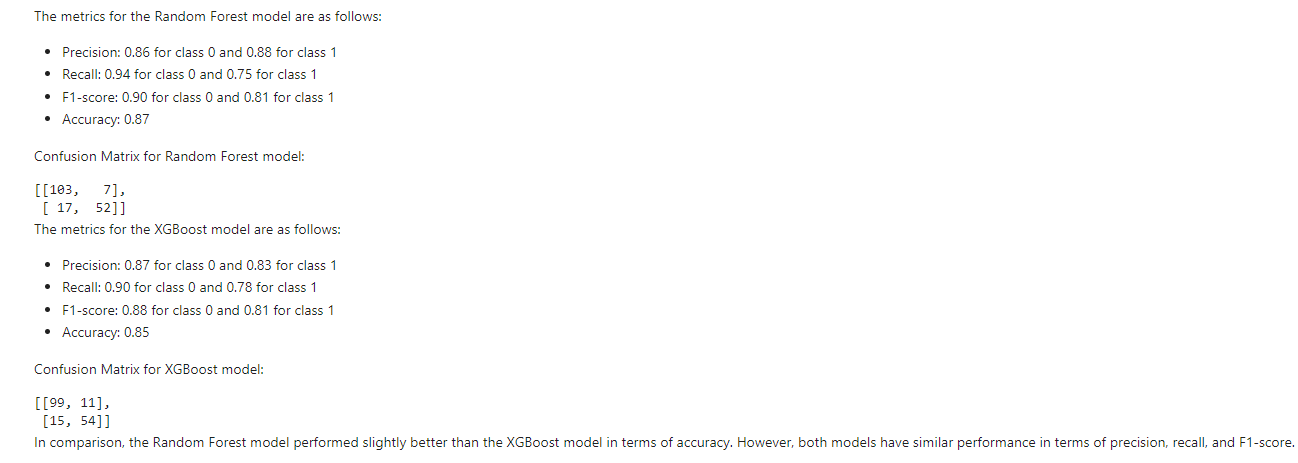
   </kbd>
   </div>

### Applications 🚀
The Python agent can be used for the following applications:

- **Code Validation**: Users can ask the agent to review and improve their Python code, enhancing its quality and efficiency.
- **Chart Generation**: Users can request charts and graphs to visualize data, aiding in data analysis.
- **Machine Learning**: Users can leverage the agent to build, train, and evaluate machine learning models without in-depth technical expertise.
- **Model Comparison**: The agent can assist in selecting the most suitable machine learning model based on user-defined criteria.

In [1]:
!pip install openai

In [2]:
import pandas as pd
import logging
import requests
import time
import re
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup
from tenacity import retry, stop_after_attempt,wait_fixed
import inspect # Import the 'inspect' module to inspect the function and retrieve its docstring and parameters
from pydantic import create_model, Field
from typing import Optional
import json

In [3]:
import openai
import os
from getpass import getpass
openai.api_key  = getpass()
model_name="gpt-4-0613"

 ···················································


# Python Function

This function describes the `python` function, which returns the result of executing Python code provided as the `code` parameter. If the execution fails, it returns an error message. Users should use any error message to debug and regenerate the code if needed.

## Function Details

- **Name**: `python`

- **Description**: This function executes Python code provided as the `code` parameter. If the execution fails, it returns an error message. Users should use any error message to debug and regenerate the code if needed.

## Parameters

The function accepts the following parameter:

**Title:**Input for `python`

- **Type**: object

- **Properties**:

    - `code`:

        - **Title**: Code
        - **Description**: Provide Python code to execute
        - **Type**: string

- **Required**: `code`

In [4]:
# Define a function 'schema' that takes a function 'f' as its argument
def schema(f):
    # Get the docstring of the input function 'f'
    docstring = inspect.getdoc(f)

    # Get the parameters of the input function 'f' and their annotations
    params = inspect.signature(f).parameters.items()

    # Create a dictionary 'kw' that will store parameter names, annotations, and default values (if any)
    kw = {n: (o.annotation, ... if o.default == inspect.Parameter.empty else o.default)
          for n, o in params}

    # Create a schema for the input function 'f' using the 'create_model' function, including parameter details
    s = create_model(f'Input for `{f.__name__}`', **kw).schema()

    # Return a dictionary containing information about the function
    return dict(name=f.__name__, description=docstring, parameters=s)

In [6]:
# Import necessary modules
import ast           # For abstract syntax tree manipulation
import traceback     # For handling exceptions

# Define a function 'python' that takes a 'code' parameter, which is a string containing Python code
def python(code: str = Field(..., description="Provide code only in Python")):
    """
    Execute the provided 'code' using Python and return the result. If execution fails, return an error message.
    Users should use any error message provided to debug and regenerate the code if needed.
    Always use this tool to verify the code
    """
    try:
        # Prompt the user to confirm if they want to proceed with code execution
        go = input(f'Proceed with execution?\n```\n{code}\n```\n')
        
        # If the user does not confirm with 'y', return a failure message
        if go.lower() != 'y':
            return '#FAIL#'
        
        # Parse the provided 'code' into an abstract syntax tree (AST)
        tree = ast.parse(code)
        
        # Get the last node of the AST (typically the result of execution)
        last_node = tree.body[-1] if tree.body else None
        
        # If the last node is an expression, modify the AST to capture the result
        if isinstance(last_node, ast.Expr):
            tgts = [ast.Name(id='_result', ctx=ast.Store())]
            assign = ast.Assign(targets=tgts, value=last_node.value)
            tree.body[-1] = ast.fix_missing_locations(assign)

        # Create a namespace 'ns' and execute the modified AST in it
        ns = {}
        exec(compile(tree, filename='<ast>', mode='exec'), ns)
        
        # Get the result from the namespace or return "None" if there is no result
        result = ns.get('_result', None)
        
        # Convert the result to a string and return it (or "None" if there is no result)
        return str(result) if result is not None else "None"
    
    # Handle exceptions and return an error message
    except Exception as e:
        # Get the error message as a formatted string using traceback
        error_message = str(traceback.format_exc())
        
        # Append instructions for users to regenerate the code
        return error_message + "\nRegenerate the code understanding the above error message, then reexecute the function with updated code"

In [7]:
schema(python)

{'name': 'python',
 'description': "Execute the provided 'code' using Python and return the result. If execution fails, return an error message.\nUsers should use any error message provided to debug and regenerate the code if needed.\nAlways use this tool to verify the code",
 'parameters': {'title': 'Input for `python`',
  'type': 'object',
  'properties': {'code': {'title': 'Code',
    'description': 'Provide code only in Python',
    'type': 'string'}},
  'required': ['code']}}

In [8]:
functions = [schema(python)]

In [9]:
available_functions = {
    "python":python
        } 

In [10]:
import inspect

# helper method used to check if the correct arguments are provided to a function
def check_args(function, args):
    sig = inspect.signature(function)
    params = sig.parameters

    # Check if there are extra arguments
    for name in args:
        if name not in params:
            return False
    # Check if the required arguments are provided 
    for name, param in params.items():
        if param.default is param.empty and name not in args:
            return False

    return True

# Function: run_multiturn_conversation

## Step 1: Sending Conversation to GPT
- The `run_multiturn_conversation` function is decorated with the `@retry` decorator from the Tenacity library, which retries the function upon failure.
- It sends a conversation and available functions to GPT using the OpenAI API.

## Step 2: Checking for Function Calls
- The code checks if GPT wants to call a function in the conversation response.
- If a function call is recommended by GPT, it extracts the function call details.

## Step 3: Calling the Function
- It calls the function recommended by GPT, provided that the function exists and has the correct number of arguments.
- The function's response is printed.

## Step 4: Updating the Conversation
- The code adds the assistant's response and the function's response to the ongoing conversation.
- It prints the messages in the updated conversation.
- The updated conversation is sent back to GPT for the next response.

## Step 5: Iterating Until Completion
- Steps 2 to 4 are repeated in a loop until GPT no longer recommends a function call.
- The final response from GPT is returned.

This code defines a function `run_multiturn_conversation` that facilitates multi-turn conversations with GPT, handling function calls and their responses during the conversation.


In [11]:
from tenacity import retry, wait_random_exponential, stop_after_attempt

@retry(wait=wait_random_exponential(multiplier=1, max=400), stop=stop_after_attempt(5))
def run_multiturn_conversation(messages, functions, available_functions, deployment_id):
    # Step 1: send the conversation and available functions to GPT

    response = openai.ChatCompletion.create(
        model=model_name,
        messages=messages,
        functions=functions,
        function_call="auto", 
        temperature=0
    )

#     print(response)
    # Step 2: check if GPT wanted to call a function
    while response["choices"][0]["finish_reason"] == 'function_call':
        response_message = response["choices"][0]["message"]
        print("Recommended Function call:")
        print(response_message.get("function_call"))
        print()
        
        # Step 3: call the function
        # Note: the JSON response may not always be valid; be sure to handle errors
        
        function_name = response_message["function_call"]["name"]
        
        # verify function exists
        if function_name not in available_functions:
            return "Function " + function_name + " does not exist"
        function_to_call = available_functions[function_name]  
                
        try:
            # verify function has correct number of arguments
            function_args = json.loads(response_message["function_call"]["arguments"])
        except Exception as e:
            # Get the error message as a formatted string using traceback
            error_message = str(traceback.format_exc())
            print(error_message)
        
        if check_args(function_to_call, function_args) is False:
            return "Invalid number of arguments for function: " + function_name
        function_response = function_to_call(**function_args)
        
        print("Output of function call:")
        print(function_response)
        print()
        
        # Step 4: send the info on the function call and function response to GPT
        
        # adding assistant response to messages
        messages.append(
            {
                "role": response_message["role"],
                "name": response_message["function_call"]["name"],
                "content": response_message["function_call"]["arguments"],
            }
        )

        # adding function response to messages
        messages.append(
            {
                "role": "function",
                "name": function_name,
                "content": function_response,
            }
        )  # extend conversation with function response

        print("Messages in next request:")
        for message in messages:
            print(message)
        print()

        response = openai.ChatCompletion.create(
            messages=messages,
            model=model_name,
            function_call="auto",
            functions=functions,
            temperature=0
        )  # get a new response from GPT where it can see the function response

    return response

In [15]:
#query = "Find fibonacci number for 200"
query = "Create a chart which shows 50% Microsoft, 20% Nvidia and 30% Google"

Recommended Function call:
{
  "name": "python",
  "arguments": "{\n  \"code\": \"import matplotlib.pyplot as plt\\n\\n# Data to plot\\nlabels = 'Microsoft', 'Nvidia', 'Google'\\nsizes = [50, 20, 30]\\ncolors = ['gold', 'yellowgreen', 'lightcoral']\\nexplode = (0.1, 0, 0)  # explode 1st slice\\n\\n# Plot\\nplt.pie(sizes, explode=explode, labels=labels, colors=colors,\\nautopct='%1.1f%%', shadow=True, startangle=140)\\n\\nplt.axis('equal')\\nplt.savefig('temp_images/pie_chart.png')\\nplt.show()\"\n}"
}



Proceed with execution?
```
import matplotlib.pyplot as plt

# Data to plot
labels = 'Microsoft', 'Nvidia', 'Google'
sizes = [50, 20, 30]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.savefig('temp_images/pie_chart.png')
plt.show()
```
 y


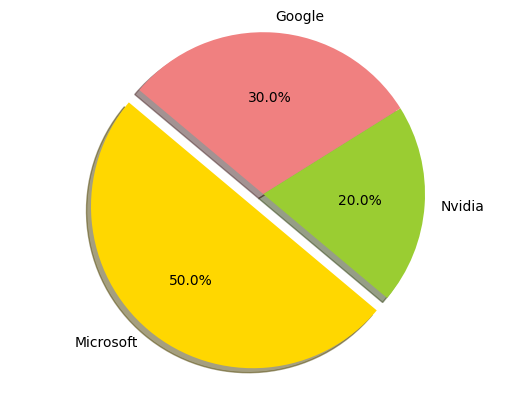

Output of function call:
None

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.\n                  If you are going to create a code, always follow best practise and add try and exception block to get the error. \n                  Do not miss: If you are creating a plot or image then generate code to save it in local system by creating a folder `temp_images`and then display it as markdown in return. \n                  VERY IMPORTANT - Always use `python` tool to verify generated code\n                  Create error free json to execute function calls\n                  '}
{'role': 'user', 'content': 'Create a chart which shows 50% Microsoft, 20% Nvidia and 30% Goo

Proceed with execution?
```
import matplotlib.pyplot as plt

# Data to plot
labels = 'Microsoft', 'Nvidia', 'Google'
sizes = [50, 20, 30]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.savefig('temp_images/pie_chart.png')
plt.close()
```
 y


Output of function call:
None

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.\n                  If you are going to create a code, always follow best practise and add try and exception block to get the error. \n                  Do not miss: If you are creating a plot or image then generate code to save it in local system by creating a folder `temp_images`and then display it as markdown in return. \n                  VERY IMPORTANT - Always use `python` tool to verify generated code\n                  Create error free json to execute function calls\n                  '}
{'role': 'user', 'content': 'Create a chart which shows 50% Microsoft, 20% Nvidia and 30% Goo

In [16]:
# Can add system prompting to guide the model to call functions and perform in specific ways
next_messages = [{"role": "system", "content": """Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.
                  If you are going to create a code, always follow best practise and add try and exception block to get the error. 
                  Do not miss: If you are creating a plot or image then generate code to save it in local system by creating a folder `temp_images`and then display it as markdown in return. 
                  VERY IMPORTANT - Always use `python` tool to verify generated code
                  Create error free json to execute function calls
                  """}]
next_messages.append({"role": "user", "content": f"""{query}"""})

assistant_response = run_multiturn_conversation(next_messages, functions, available_functions, model_name)
print("Final Response:")
print(assistant_response["choices"][0]["message"])
print("Conversation complete!")  

In [17]:
from IPython.display import Markdown
display(Markdown(assistant_response["choices"][0]["message"]['content']))

The pie chart has been successfully created and saved in the 'temp_images' folder with the filename 'pie_chart.png'. You can view the chart by accessing this file.

Here is the chart:

![Pie Chart](temp_images/pie_chart.png)

## Extend the function to include excel files as well

In [18]:
# Define a function called 'excel_csv_python' that takes two arguments: 'code' (a Python code snippet) and 'filename' (path to an Excel or CSV file).
def excel_csv_python(code: str = Field(..., description="Provide a code only in Python"), filename: str = Field(None, description="Provide path to an Excel or CSV file")):
    """
    This function is used to run analysis on CSV or Excel files.
    It returns the result of executing the 'code' using Python. If execution fails, it returns the error message.
    You should use any error message from this code to regenerate the code and execute the Python function again with rectified code.
    The file will be available inside a dataframe 'df'.
    Always use 'excel_csv_python' to execute Python code.
    Always analyze the error in detail, think step by step before producing correct code.
    """

    try:
        # Prompt the user for confirmation before executing the 'code'.
        go = input(f'Proceed with execution?\n```\n{code}\n```\n')
        if go.lower() != 'y':
            return '#FAIL#'

        # Parse the 'code' into an Abstract Syntax Tree (AST).
        tree = ast.parse(code)
        last_node = tree.body[-1] if tree.body else None

        # If the last node in the AST is an expression, modify the AST to capture the result.
        if isinstance(last_node, ast.Expr):
            tgts = [ast.Name(id='_result', ctx=ast.Store())]
            assign = ast.Assign(targets=tgts, value=last_node.value)
            tree.body[-1] = ast.fix_missing_locations(assign)

        # Create a namespace dictionary 'ns' with 'filename' if provided.
        ns = {'filename': filename} if filename else {}

        # Execute the modified AST in the 'ns' namespace.
        exec(compile(tree, filename='<ast>', mode='exec'), ns)

        # Retrieve the result from the 'ns' namespace.
        result = ns.get('_result', None)
        
        # Convert the result to a string if it's not None.
        return str(result) if result is not None else "None"
    except Exception as e:
        # If an exception occurs during execution, capture the error message and return it.
        error_message = str(traceback.format_exc())
        return error_message + "\n Regenerate the code understanding the above error code, reexecute the function with updated code"

In [19]:
schema(excel_csv_python)

{'name': 'excel_csv_python',
 'description': "This function is used to run analysis on CSV or Excel files.\nIt returns the result of executing the 'code' using Python. If execution fails, it returns the error message.\nYou should use any error message from this code to regenerate the code and execute the Python function again with rectified code.\nThe file will be available inside a dataframe 'df'.\nAlways use 'excel_csv_python' to execute Python code.\nAlways analyze the error in detail, think step by step before producing correct code.",
 'parameters': {'title': 'Input for `excel_csv_python`',
  'type': 'object',
  'properties': {'code': {'title': 'Code',
    'description': 'Provide a code only in Python',
    'type': 'string'},
   'filename': {'title': 'Filename',
    'description': 'Provide path to an Excel or CSV file',
    'type': 'string'}},
  'required': ['code']}}

In [20]:
functions = [schema(excel_csv_python)]

In [21]:
available_functions = {
    "excel_csv_python":excel_csv_python,
        } 

In [22]:
query = "Create basic statistics for csv file `/kaggle/input/titanic/train.csv`"

In [23]:
# Can add system prompting to guide the model to call functions and perform in specific ways
next_messages = [{"role": "system", "content": """Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.
                  If you are going to create a code, always follow best practise and add try and exception block to get the error. 
                  Read excel or csv file provided and generate code for the same.
                  Do not miss: If you are creating a plot or image then generate code to save it in local system by creating a folder `temp_images`and then display it as markdown in return. 
                  VERY IMPORTANT - Always use `excel_csv_python` tool to verify generated code
                  Very Important - Act as an expert Python coder when you are asked to generate a code, always import appropriate libraries, read files and check the code before publishing
                  Generate code as if its a new code and you do not have reference to old generated code in coversation so always import appropriate libraries, read files and check the code before publishing whenever asked to generate the code.
                  """}]
next_messages.append({"role": "user", "content": f"""{query}"""})

assistant_response = run_multiturn_conversation(next_messages, functions, available_functions, model_name)
print("Final Response:")
print(assistant_response["choices"][0]["message"])
print("Conversation complete!")  

Recommended Function call:
{
  "name": "excel_csv_python",
  "arguments": "{\n  \"code\": \"df.describe(include='all')\",\n  \"filename\": \"/kaggle/input/titanic/train.csv\"\n}"
}



Proceed with execution?
```
df.describe(include='all')
```
 y


Output of function call:
Traceback (most recent call last):
  File "/tmp/ipykernel_815/15315607.py", line 32, in excel_csv_python
    exec(compile(tree, filename='<ast>', mode='exec'), ns)
  File "<ast>", line 1, in <module>
NameError: name 'df' is not defined

 Regenerate the code understanding the above error code, reexecute the function with updated code

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.\n                  If you are going to create a code, always follow best practise and add try and exception block to get the error. \n                  Read excel or csv file provided and generate code for the same.\n                  Do not miss: If you are creat

Proceed with execution?
```
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Generate basic statistics
df.describe(include='all')
```
 y


Output of function call:
        PassengerId    Survived      Pclass                     Name   Sex  \
count    891.000000  891.000000  891.000000                      891   891   
unique          NaN         NaN         NaN                      891     2   
top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
freq            NaN         NaN         NaN                        1   577   
mean     446.000000    0.383838    2.308642                      NaN   NaN   
std      257.353842    0.486592    0.836071                      NaN   NaN   
min        1.000000    0.000000    1.000000                      NaN   NaN   
25%      223.500000    0.000000    2.000000                      NaN   NaN   
50%      446.000000    0.000000    3.000000                      NaN   NaN   
75%      668.500000    1.000000    3.000000                      NaN   NaN   
max      891.000000    1.000000    3.000000                      NaN   NaN   

               Age       SibSp       P

In [24]:
from IPython.display import Markdown
display(Markdown(assistant_response["choices"][0]["message"]['content']))

The basic statistics for the CSV file `/kaggle/input/titanic/train.csv` are as follows:

- There are 891 records in the dataset.
- The average (mean) age of passengers is approximately 29.7 years.
- The youngest passenger is about 0.42 years old (approximately 5 months), and the oldest is 80 years old.
- On average, passengers have about 0.52 siblings/spouses aboard and 0.38 parents/children aboard.
- The average fare is approximately 32.20.
- The minimum fare is 0 and the maximum fare is 512.33.
- The most common embarkation port is 'S' (Southampton), with 644 occurrences.
- There are missing values in 'Age', 'Cabin', and 'Embarked' columns.
- The 'Name', 'Sex', 'Ticket', 'Cabin', and 'Embarked' columns are categorical variables with various unique values.
- The 'PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', and 'Fare' columns are numerical variables.

Recommended Function call:
{
  "name": "excel_csv_python",
  "arguments": "{\n  \"code\": \"import matplotlib.pyplot as plt\\nimport seaborn as sns\\n\\n# Calculate target distribution\\ntarget_distribution = df['Survived'].value_counts()\\n\\n# Create a bar plot\\nplt.figure(figsize=(10,6))\\nsns.barplot(target_distribution.index, target_distribution.values, alpha=0.8)\\nplt.title('Target Distribution')\\nplt.ylabel('Number of Occurrences', fontsize=12)\\nplt.xlabel('Survived', fontsize=12)\\n\\n# Save the plot\\nplt.savefig('temp_images/target_distribution.png')\\n\\n# Display the target distribution\\ntarget_distribution\",\n  \"filename\": \"/kaggle/input/titanic/train.csv\"\n}"
}



Proceed with execution?
```
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate target distribution
target_distribution = df['Survived'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(target_distribution.index, target_distribution.values, alpha=0.8)
plt.title('Target Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Survived', fontsize=12)

# Save the plot
plt.savefig('temp_images/target_distribution.png')

# Display the target distribution
target_distribution
```
 y


Output of function call:
Traceback (most recent call last):
  File "/tmp/ipykernel_815/15315607.py", line 32, in excel_csv_python
    exec(compile(tree, filename='<ast>', mode='exec'), ns)
  File "<ast>", line 5, in <module>
NameError: name 'df' is not defined

 Regenerate the code understanding the above error code, reexecute the function with updated code

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.\n                  If you are going to create a code, always follow best practise and add try and exception block to get the error. \n                  Read excel or csv file provided and generate code for the same.\n                  Do not miss: If you are creat

Proceed with execution?
```
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataset
df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Calculate target distribution
target_distribution = df['Survived'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(target_distribution.index, target_distribution.values, alpha=0.8)
plt.title('Target Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Survived', fontsize=12)

# Create directory if it doesn't exist
if not os.path.exists('temp_images'):
    os.makedirs('temp_images')

# Save the plot
plt.savefig('temp_images/target_distribution.png')

# Display the target distribution
target_distribution
```
 y


Output of function call:
Traceback (most recent call last):
  File "/tmp/ipykernel_815/15315607.py", line 32, in excel_csv_python
    exec(compile(tree, filename='<ast>', mode='exec'), ns)
  File "<ast>", line 14, in <module>
TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

 Regenerate the code understanding the above error code, reexecute the function with updated code

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.\n                  If you are going to create a code, always follow best practise and add try and exception block to get the error. \n                  Read excel or csv file provided and generate code for the same.\n     

Proceed with execution?
```
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataset
df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Calculate target distribution
target_distribution = df['Survived'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=target_distribution.index, y=target_distribution.values, alpha=0.8)
plt.title('Target Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Survived', fontsize=12)

# Create directory if it doesn't exist
if not os.path.exists('temp_images'):
    os.makedirs('temp_images')

# Save the plot
plt.savefig('temp_images/target_distribution.png')

# Display the target distribution
target_distribution
```
 y


Output of function call:
Survived
0    549
1    342
Name: count, dtype: int64

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.\n                  If you are going to create a code, always follow best practise and add try and exception block to get the error. \n                  Read excel or csv file provided and generate code for the same.\n                  Do not miss: If you are creating a plot or image then generate code to save it in local system by creating a folder `temp_images`and then display it as markdown in return. \n                  VERY IMPORTANT - Always use `excel_csv_python` tool to verify generated code\n                  Very Important - Act as

<Figure size 1000x600 with 0 Axes>

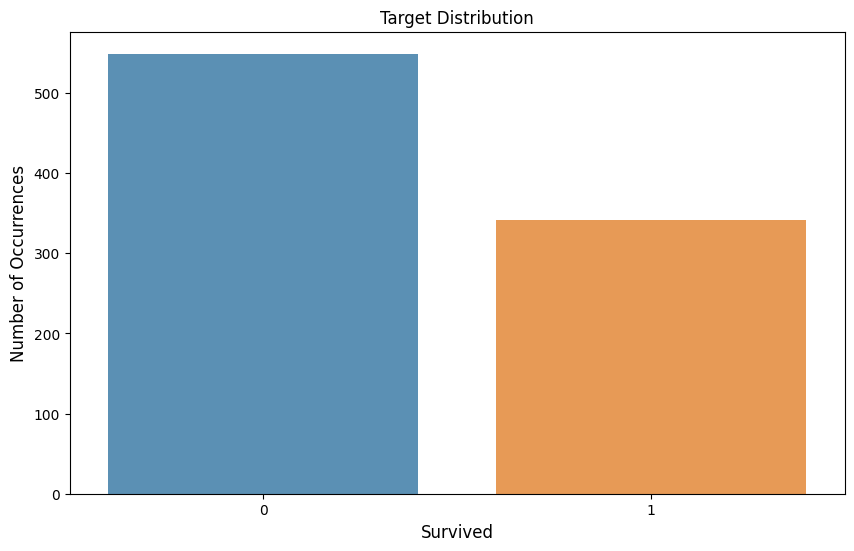

In [25]:
next_messages.append({"role": "user", "content": f"""Can you provide target distribution of column `survival` and create appropriate chart for the same"""})

assistant_response = run_multiturn_conversation(next_messages, functions, available_functions, model_name)

In [26]:
from IPython.display import Markdown
display(Markdown(assistant_response["choices"][0]["message"]['content']))

The target distribution of the 'Survived' column is as follows:

- 549 passengers did not survive.
- 342 passengers survived.

The bar chart has been saved as 'target_distribution.png' in the 'temp_images' directory.

Here is the chart:

![Target Distribution](temp_images/target_distribution.png)

In [27]:
next_messages.append({"role": "user", "content": f"""Create basic random forest model with 80% training split and 20% validation split and provide all the metrics for the model. The target column is `survival`"""})

assistant_response = run_multiturn_conversation(next_messages, functions, available_functions, model_name)

Recommended Function call:
{
  "name": "excel_csv_python",
  "arguments": "{\n  \"code\": \"from sklearn.model_selection import train_test_split\\nfrom sklearn.ensemble import RandomForestClassifier\\nfrom sklearn.metrics import classification_report, confusion_matrix, accuracy_score\\nfrom sklearn.preprocessing import LabelEncoder\\n\\n# Drop rows with missing target\\ndf.dropna(subset=['Survived'], inplace=True)\\n\\n# Separate target from predictors\\ndf['Survived'] = df['Survived'].astype('int')\\n\\n# Select categorical columns\\nobject_cols = [col for col in df.columns if df[col].dtype == 'object']\\n\\n# Apply label encoder to each column with categorical data\\nlabel_encoder = LabelEncoder()\\nfor col in object_cols:\\n    df[col] = label_encoder.fit_transform(df[col].astype(str))\\n\\n# Fill NA values\\nfor col in df.columns:\\n    df[col] = df[col].fillna(df[col].mean())\\n\\n# Split the data into training and validation sets\\nX_train, X_valid, y_train, y_valid = train_test_

Proceed with execution?
```
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Drop rows with missing target
df.dropna(subset=['Survived'], inplace=True)

# Separate target from predictors
df['Survived'] = df['Survived'].astype('int')

# Select categorical columns
object_cols = [col for col in df.columns if df[col].dtype == 'object']

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Fill NA values
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(df.drop('Survived', axis=1), df['Survived'], test_size=0.2, random_state=0)

# Define the model
model = Ra

Output of function call:
Traceback (most recent call last):
  File "/tmp/ipykernel_815/15315607.py", line 32, in excel_csv_python
    exec(compile(tree, filename='<ast>', mode='exec'), ns)
  File "<ast>", line 7, in <module>
NameError: name 'df' is not defined

 Regenerate the code understanding the above error code, reexecute the function with updated code

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.\n                  If you are going to create a code, always follow best practise and add try and exception block to get the error. \n                  Read excel or csv file provided and generate code for the same.\n                  Do not miss: If you are creat

Proceed with execution?
```
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Drop rows with missing target
df.dropna(subset=['Survived'], inplace=True)

# Separate target from predictors
df['Survived'] = df['Survived'].astype('int')

# Select categorical columns
object_cols = [col for col in df.columns if df[col].dtype == 'object']

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Fill NA values
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(df.drop('Survi

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       110
           1       0.89      0.74      0.81        69

    accuracy                           0.87       179
   macro avg       0.87      0.84      0.85       179
weighted avg       0.87      0.87      0.86       179

Confusion Matrix:
[[104   6]
 [ 18  51]]
Accuracy Score:
0.8659217877094972
Output of function call:
None

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.\n                  If you are going to create a code, always follow best practise and add try and exception block to get the error. \n                  Read excel or cs

Proceed with execution?
```
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/kaggle/input/titanic/train.csv')
print('Data loaded successfully')

# Drop rows with missing target
df.dropna(subset=['Survived'], inplace=True)
print('Dropped rows with missing target')

# Separate target from predictors
df['Survived'] = df['Survived'].astype('int')
print('Separated target from predictors')

# Select categorical columns
object_cols = [col for col in df.columns if df[col].dtype == 'object']
print('Selected categorical columns')

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))
print('Applied label encoder')

# Fill NA values
f

Data loaded successfully
Dropped rows with missing target
Separated target from predictors
Selected categorical columns
Applied label encoder
Filled NA values
Split the data into training and validation sets
Defined the model
Fitted the model
Got predictions
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       110
           1       0.89      0.74      0.81        69

    accuracy                           0.87       179
   macro avg       0.87      0.84      0.85       179
weighted avg       0.87      0.87      0.86       179

Confusion Matrix:
[[104   6]
 [ 18  51]]
Accuracy Score:
0.8659217877094972
Output of function call:
None

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to a

Proceed with execution?
```
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Drop rows with missing target
df.dropna(subset=['Survived'], inplace=True)

# Separate target from predictors
df['Survived'] = df['Survived'].astype('int')

# Select categorical columns
object_cols = [col for col in df.columns if df[col].dtype == 'object']

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Fill NA values
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(df.drop('Survi

Output of function call:
['              precision    recall  f1-score   support\n\n           0       0.85      0.95      0.90       110\n           1       0.89      0.74      0.81        69\n\n    accuracy                           0.87       179\n   macro avg       0.87      0.84      0.85       179\nweighted avg       0.87      0.87      0.86       179\n', array([[104,   6],
       [ 18,  51]]), 0.8659217877094972]

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.\n                  If you are going to create a code, always follow best practise and add try and exception block to get the error. \n                  Read excel or csv file provided and generate cod

In [28]:
from IPython.display import Markdown
display(Markdown(assistant_response["choices"][0]["message"]['content']))

The Random Forest model has the following metrics:

- Classification Report:
```
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       110
           1       0.89      0.74      0.81        69

    accuracy                           0.87       179
   macro avg       0.87      0.84      0.85       179
weighted avg       0.87      0.87      0.86       179
```

- Confusion Matrix:
```
[[104,   6],
 [ 18,  51]]
```

- Accuracy Score: 0.8659217877094972

This means that the model has an accuracy of approximately 86.59%. The precision, recall, and f1-score for each class can also be observed in the classification report. The confusion matrix shows that the model correctly predicted 104 instances of class 0 and 51 instances of class 1, while it incorrectly predicted 6 instances of class 0 and 18 instances of class 1.

In [29]:
next_messages.append({"role": "user", "content": f"""Create basic random forest model with 80% training split and 20% validation split and provide all the metrics for the model. The target column is `survival`, you can create your own features to improve the accuracy"""})

assistant_response = run_multiturn_conversation(next_messages, functions, available_functions, model_name)

Recommended Function call:
{
  "name": "excel_csv_python",
  "arguments": "{\n  \"code\": \"import pandas as pd\\nfrom sklearn.model_selection import train_test_split\\nfrom sklearn.ensemble import RandomForestClassifier\\nfrom sklearn.metrics import classification_report, confusion_matrix, accuracy_score\\nfrom sklearn.preprocessing import LabelEncoder\\n\\n# Load the dataset\\ndf = pd.read_csv('/kaggle/input/titanic/train.csv')\\n\\n# Drop rows with missing target\\ndf.dropna(subset=['Survived'], inplace=True)\\n\\n# Separate target from predictors\\ndf['Survived'] = df['Survived'].astype('int')\\n\\n# Select categorical columns\\nobject_cols = [col for col in df.columns if df[col].dtype == 'object']\\n\\n# Apply label encoder to each column with categorical data\\nlabel_encoder = LabelEncoder()\\nfor col in object_cols:\\n    df[col] = label_encoder.fit_transform(df[col].astype(str))\\n\\n# Fill NA values\\nfor col in df.columns:\\n    df[col] = df[col].fillna(df[col].mean())\\n\\n#

Proceed with execution?
```
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Drop rows with missing target
df.dropna(subset=['Survived'], inplace=True)

# Separate target from predictors
df['Survived'] = df['Survived'].astype('int')

# Select categorical columns
object_cols = [col for col in df.columns if df[col].dtype == 'object']

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Fill NA values
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())

# Create new feature FamilySize as a combination of SibSp and Parch
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

#

Output of function call:
['              precision    recall  f1-score   support\n\n           0       0.86      0.94      0.90       110\n           1       0.88      0.75      0.81        69\n\n    accuracy                           0.87       179\n   macro avg       0.87      0.84      0.85       179\nweighted avg       0.87      0.87      0.86       179\n', array([[103,   7],
       [ 17,  52]]), 0.8659217877094972]

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools that can be utilized to gather information and provide accurate responses. Occasionally, you may need to apply a series of tools in a specific order to obtain comprehensive answers for your users.\n                  If you are going to create a code, always follow best practise and add try and exception block to get the error. \n                  Read excel or csv file provided and generate cod

In [30]:
from IPython.display import Markdown
display(Markdown(assistant_response["choices"][0]["message"]['content']))

The Random Forest model with the added 'FamilySize' feature has the following metrics:

- Classification Report:
```
              precision    recall  f1-score   support
           0       0.86      0.94      0.90       110
           1       0.88      0.75      0.81        69
    accuracy                           0.87       179
   macro avg       0.87      0.84      0.85       179
weighted avg       0.87      0.87      0.86       179
```

- Confusion Matrix:
```
[[103,   7],
 [ 17,  52]]
```

- Accuracy Score: 0.8659217877094972

This means that the model has an accuracy of approximately 86.59%. The precision, recall, and f1-score for each class (0 and 1) are also provided. The confusion matrix shows that the model correctly predicted 103 instances of class 0 and 52 instances of class 1, while it incorrectly predicted 7 instances of class 0 and 17 instances of class 1.

In [31]:
next_messages.append({"role": "user", "content": f"""Create advance random forest and xgboost models with 80% training split and 20% validation split and provide all the metrics for the model. The target column is `survival`, you can create your own features to improve the accuracy. Compare both the models at the end"""})

assistant_response = run_multiturn_conversation(next_messages, functions, available_functions, model_name)

Recommended Function call:
{
  "name": "excel_csv_python",
  "arguments": "{\n  \"code\": \"import pandas as pd\\nfrom sklearn.model_selection import train_test_split\\nfrom sklearn.ensemble import RandomForestClassifier\\nfrom xgboost import XGBClassifier\\nfrom sklearn.metrics import classification_report, confusion_matrix, accuracy_score\\nfrom sklearn.preprocessing import LabelEncoder\\n\\n# Load the dataset\\ndf = pd.read_csv('/kaggle/input/titanic/train.csv')\\n\\n# Drop rows with missing target\\ndf.dropna(subset=['Survived'], inplace=True)\\n\\n# Separate target from predictors\\ndf['Survived'] = df['Survived'].astype('int')\\n\\n# Select categorical columns\\nobject_cols = [col for col in df.columns if df[col].dtype == 'object']\\n\\n# Apply label encoder to each column with categorical data\\nlabel_encoder = LabelEncoder()\\nfor col in object_cols:\\n    df[col] = label_encoder.fit_transform(df[col].astype(str))\\n\\n# Fill NA values\\nfor col in df.columns:\\n    df[col] = d

Proceed with execution?
```
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Drop rows with missing target
df.dropna(subset=['Survived'], inplace=True)

# Separate target from predictors
df['Survived'] = df['Survived'].astype('int')

# Select categorical columns
object_cols = [col for col in df.columns if df[col].dtype == 'object']

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Fill NA values
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())

# Create new feature FamilySize as a combination of SibSp and Parch
df['FamilySize'] 

Output of function call:
['              precision    recall  f1-score   support\n\n           0       0.86      0.94      0.90       110\n           1       0.88      0.75      0.81        69\n\n    accuracy                           0.87       179\n   macro avg       0.87      0.84      0.85       179\nweighted avg       0.87      0.87      0.86       179\n', array([[103,   7],
       [ 17,  52]]), 0.8659217877094972, '              precision    recall  f1-score   support\n\n           0       0.85      0.90      0.88       110\n           1       0.83      0.75      0.79        69\n\n    accuracy                           0.84       179\n   macro avg       0.84      0.83      0.83       179\nweighted avg       0.84      0.84      0.84       179\n', array([[99, 11],
       [17, 52]]), 0.8435754189944135]

Messages in next request:
{'role': 'system', 'content': 'Welcome to Assistant, your reliable resource for answering user queries. Our Assistant is equipped with a range of tools tha

In [32]:
from IPython.display import Markdown
display(Markdown(assistant_response["choices"][0]["message"]['content']))

The metrics for the Random Forest model are:

Classification Report:
```
              precision    recall  f1-score   support
           0       0.86      0.94      0.90       110
           1       0.88      0.75      0.81        69
    accuracy                           0.87       179
   macro avg       0.87      0.84      0.85       179
weighted avg       0.87      0.87      0.86       179
```

Confusion Matrix:
```
[[103,   7],
 [ 17,  52]]
```

Accuracy Score: 0.8659217877094972

The metrics for the XGBoost model are:

Classification Report:
```
              precision    recall  f1-score   support
           0       0.85      0.90      0.88       110
           1       0.83      0.75      0.79        69
    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179
```

Confusion Matrix:
```
[[99, 11],
 [17, 52]]
```

Accuracy Score: 0.8435754189944135

In comparison, the Random Forest model performed slightly better than the XGBoost model in terms of accuracy.